In [1]:
from pyspark.sql import SparkSession

### Exercise 1: Create a spark session

In [2]:
spark = SparkSession.builder.config("spark.master", 'local').getOrCreate()

# Data Schema

Brazilian E-Commerce Public Dataset by Olist

https://www.kaggle.com/olistbr/brazilian-ecommerce

### Exercise 2: Spark read csv from this path ('/shared-data/Apr20/data/Module3/olist_order_items_dataset.csv') into a dataframe with header.

In [3]:
df = spark.read.option('header', 'true').csv('/shared-data/Apr20/data/Module3/olist_order_items_dataset.csv')

In [4]:
df.show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date| price|freight_value|
+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.90|        13.29|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.90|        19.93|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48:30|199.00|        17.87|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|2018-08-15 10:10:18| 12.99|        12.79|
|00042b26cf59d7ce6...|            1|ac6c3623068f30de0...|df560393f3a51e745...|2017-02-13 13:57:51|199.90|        18.14|
+--------------------+-------------+----

In [5]:
df.explain()

== Physical Plan ==
FileScan csv [order_id#16,order_item_id#17,product_id#18,seller_id#19,shipping_limit_date#20,price#21,freight_value#22] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/shared-data/Apr20/data/Module3/olist_order_items_dataset.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<order_id:string,order_item_id:string,product_id:string,seller_id:string,shipping_limit_dat...




## Load data with a proper schema

`df.printSchema()` lists out the data type of each column. Directly loading our csv file into Spark creates a dataframe where all columns are set to String types. While, this is not ideal as we prefer to have numeric types for `price` and datetime types for `date`.

```
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- freight_value: string (nullable = true)
```


In [6]:
df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- order_item_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- freight_value: string (nullable = true)



### Let Spark to infer the schema

We can use the `inferSchema` option to ask Spark to guess the best suitable schema of the input data.

In [7]:
df_infer = spark.read.option('header', 'true').option('inferSchema', 'true').csv('/shared-data/Apr20/data/Module3/olist_order_items_dataset.csv')
df_infer.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)



### Use a user-specified schema

In [8]:
from pyspark.sql.types import StructType, StringType, TimestampType, DoubleType

my_schema = StructType() \
    .add("order_id",StringType(),True) \
    .add("order_item_id",StringType(),True) \
    .add("product_id",StringType(),True) \
    .add("seller_id",StringType(),True) \
    .add("shipping_limit_date",TimestampType(),True) \
    .add("price",DoubleType(),True) \
    .add("freight_value",DoubleType(),True)

df_user = spark.read \
    .option('header', 'true') \
    .schema(my_schema) \
    .csv('/shared-data/Apr20/data/Module3/olist_order_items_dataset.csv')

df_user.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- order_item_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)



 ## Data transform based on columns' schema
 
 A right schema makes it much easier to process our data as we can utilize native functions Spark provides to supported data types. Check [Spark documentation](https://spark.apache.org/docs/2.3.0/api/sql/index.html)  to learn more about available functions.
 
 For example, we can extract `year` and `month` information from the `shipping_limit_date` column and add them as expanded columns in our dataframe.
 
 In Spark, adding a new column is done by calling the `withColumn` interface of a dataframe:
 
 ```
df_user1 = df_user.withColumn('Y', year('shipping_limit_date'))
df_user1.show(5)
+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+----+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date| price|freight_value|   Y|
+--------------------+-------------+--------------------+--------------------+-------------------+------+-------------+----+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35|  58.9|        13.29|2017|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13| 239.9|        19.93|2017|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48:30| 199.0|        17.87|2018|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|2018-08-15 10:10:18| 12.99|        12.79|2018|
|00042b26cf59d7ce6...|            1|ac6c3623068f30de0...|df560393f3a51e745...|2017-02-13 13:57:51| 199.9|        18.14|2017|

 ```
 
 If we need to add multiple columns, we can pipe a seriese of `withColumn` calls together:
 ```
 df_user1 = df_user \
    .withColumn('Y', year('shipping_limit_date')) \
    .withColumn('M', month('shipping_limit_date'))
 ```
 
 __Note__: Spark does not allow you to modify an existing dataframe in-place. Every transform creates a new dataframe, and this is why we always assign a new dataframe to the transformed result `df_user1 = df_user.withColumn(...)`. But don't worry such a behavior might waste your ram -- Spark internally maintains linkage among transformed dataframes and minize memory usage automatically.

In [9]:
from pyspark.sql.functions import year, month

df_user1 = df_user \
    .withColumn('Y', year('shipping_limit_date')) \
    .withColumn('M', month('shipping_limit_date'))
df_user1.show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+----+---+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|   Y|  M|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+----+---+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29|2017|  9|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.9|        19.93|2017|  5|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48:30|199.0|        17.87|2018|  1|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|2018-08-15 10:10:18|12.99|        12.79|2018|  8|
|00042b26cf59d7ce6...|            1|ac6c3623068f30de0...|df560393f3a51e745...|2017-02-13 13:57:51|199.9|

# Data ETL

ETL refers to 'Extract, Transform, and Load', which is almost the first data requirement in any project. Spark dataframe make ETL easy as many typical operations are already abstracted and embedded into Spark dataframe interfaces.

## Filtering

`Filtering` is the most common `Extract` operation, where we want to focus only on data that meets certain criterias. 
For example, if we want to look at orders in year 2017, we can use the following filter:

```
df_user1.filter(df_user1.Y == 2017)
```

Similarly, you can also apply conditions with `greater`, `less`, or `not equal` to filter dataframes.


__Note__: `Y` column is of `integer` type. But if you use `df_user1.filter(df_user1.Y == "2017")`, you might be suprised that Spark still returns you the right result. This is becuase Spark trys to cast the column into a matching type to ensure the `comparison` is executable.

In [10]:
print("*** Compare with an integer")
df_user1.filter(df_user1.Y == 2017).show(2)

print("*** Compare with a string")
df_user1.filter(df_user1.Y == "2017").show(2)

*** Compare with an integer
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+----+---+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|   Y|  M|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+----+---+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29|2017|  9|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.9|        19.93|2017|  5|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+----+---+
only showing top 2 rows

*** Compare with a string
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+----+---+
|            order_id|ord

For columns with `string` type, sometime we might need to filter them by prefixes, postfixes or particular patterns. Spark provides a few string functions to make it simple for us to express these logics.

For example, if we want to work with 'order_ids' that starts with `"2"`, we can fitler the dataframe using the `substring` function:

```
df_user.filter(substring(df_user.order_id, 0, 1) == '2').show()
```

`substring` helps us extract a segment of the string based on the start and end location we provides. 


__<span style="color:red">Quiz:</span>__: How to filter `order_id` start with `2002`?

In [11]:
from pyspark.sql.functions import substring

df_user.filter(substring(df_user.order_id,0,4) == '2002').show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|20020569f2b852ebd...|            1|5c46bf87ac19e3912...|54965bbe3e4f07ae0...|2017-11-13 00:50:18| 89.9|        14.36|
|2002527d89799a0cf...|            1|3b037eb584c1cf92f...|4324dd16853115efb...|2017-10-17 18:15:09|78.85|        35.25|
|2002527d89799a0cf...|            2|e59dd207c69d86e89...|e9bc59e7b60fc3063...|2017-10-17 18:15:09|174.0|         0.21|
|2002ea16e75277eaa...|            1|a184d57c818939252...|520b493b57809f446...|2017-07-26 22:30:10| 15.0|         9.94|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+



So far we are talking about filtering rows. How should we filter the dataframe by columns, e.g. choose a subset of columns while keep every row?

Column filtering can be done by the `select` interface. If we only want to keep `order_id`, `price`, and `Y`, we can `select` in the following way:

```
df_user1.select('order_id', 'price', 'Y')
```

In [12]:
df_user1.select('order_id', 'price', 'Y').show(3)

+--------------------+-----+----+
|            order_id|price|   Y|
+--------------------+-----+----+
|00010242fe8c5a6d1...| 58.9|2017|
|00018f77f2f0320c5...|239.9|2017|
|000229ec398224ef6...|199.0|2018|
+--------------------+-----+----+
only showing top 3 rows



__<span style="color:red">Quiz:</span>__: Try to filler the dataframe whose `order_id` starts with `2002`, and only keep the `order_id` and `price` columns.

In [13]:
df_user.filter(substring(df_user.order_id,0,4) == '2002').select('order_id', 'price').show()

+--------------------+-----+
|            order_id|price|
+--------------------+-----+
|20020569f2b852ebd...| 89.9|
|2002527d89799a0cf...|78.85|
|2002527d89799a0cf...|174.0|
|2002ea16e75277eaa...| 15.0|
+--------------------+-----+



## Transform

We have shown how to add columns using the `withColumn` interface previousely. Now let's have a look other transforms.

The simplest transform is mathematic operations, e.g. addition, subtraction, multiplication, division, etc. Check [Spark documentation](https://spark.apache.org/docs/2.3.0/api/sql/index.html)  to learn more about available math functions.
For example, if we want to convert the `price` to use `thousand` dollar as its unit, we can

```
df_user.withColumn('price_in_k', df_user.price/1000).show()
```

We could also combine two columns information together. For example, we can get the `overall_price` by adding `price` and `freight_value` together.

```
df_user.withColumn('overall_price', df_user.price + df_user.freight_value).show()
```

In [14]:
df_user.withColumn('price_in_k', df_user.price/1000).show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+----------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|price_in_k|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+----------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29|    0.0589|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.9|        19.93|    0.2399|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48:30|199.0|        17.87|     0.199|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|2018-08-15 10:10:18|12.99|        12.79|   0.01299|
|00042b26cf59d7ce6...|            1|ac6c3623068f30de0...|df560393f3a51e745...|2017-02-13 1

In [15]:
df_user.withColumn('overall_price', df_user.price + df_user.freight_value).show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+------------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|     overall_price|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+------------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29|             72.19|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.9|        19.93|            259.83|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48:30|199.0|        17.87|            216.87|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|2018-08-15 10:10:18|12.99|        12.79|             25.78|
|00042b26cf59d7ce6...|            

__<span style="color:red">Quiz:</span>__: Find the square root of each oder's price

In [16]:
from pyspark.sql.functions import sqrt

df_user.withColumn('sqrt_price', sqrt(df_user.price)).show(5)

+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+------------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|        sqrt_price|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+------------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29| 7.674633541739957|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.9|        19.93|15.488705562441298|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48:30|199.0|        17.87|14.106735979665885|
|00024acbcdf0a6daa...|            1|7634da152a4610f15...|9d7a1d34a50524090...|2018-08-15 10:10:18|12.99|        12.79|3.6041642581880198|
|00042b26cf59d7ce6...|            

Remember Spark does not allow in-place transform, so each of our transform needs to be expressed by adding a new column into the dataframe. The good thing is that we can always use the `coloumn` filtering to keep only the columns we want.

## Aggregation

Aggregation is a special `transform`: Instead of altering cells on a per-row basis, aggregation works with a group of rows and generate new values from each group. Therefore, aggregation is always used together with the `groupby` operation.



In [17]:
from pyspark.sql.functions import sum, count

df_user1.groupby('Y', 'M').agg(sum('price')).show(5)

+----+---+------------------+
|   Y|  M|        sum(price)|
+----+---+------------------+
|2017|  3|343242.59999999945|
|2017|  8| 560093.3400000128|
|2017| 10| 658020.2300000164|
|2018|  1| 845279.1800000344|
|2018|  3|1030527.8400000384|
+----+---+------------------+
only showing top 5 rows



Our new column's name is "sum(price)", which is not convenient to use later. We could use `alias` to give the column a better name.

In [18]:
df_user1.groupby('Y', 'M').agg(
    sum('price').alias('monthly_total')
).show(5)

+----+---+------------------+
|   Y|  M|     monthly_total|
+----+---+------------------+
|2017|  3|343242.59999999945|
|2017|  8| 560093.3400000128|
|2017| 10| 658020.2300000164|
|2018|  1| 845279.1800000344|
|2018|  3|1030527.8400000384|
+----+---+------------------+
only showing top 5 rows



It is also possible to have multiple aggregation with each group. For example, we can get monthly price and monthly count using the following call

```
df_user1.groupby('Y', 'M').agg(
    sum('price').alias('monthly_total'),
    count('price').alias('montyly_count'),
)
```

In [19]:
df_user1.groupby('Y', 'M').agg(
    sum('price').alias('monthly_total'),
    count('price').alias('montyly_count'),
).show(5)

+----+---+------------------+-------------+
|   Y|  M|     monthly_total|montyly_count|
+----+---+------------------+-------------+
|2017|  3|343242.59999999945|         2751|
|2017|  8| 560093.3400000128|         5042|
|2017| 10| 658020.2300000164|         5189|
|2018|  1| 845279.1800000344|         7492|
|2018|  3|1030527.8400000384|         8759|
+----+---+------------------+-------------+
only showing top 5 rows



You may notice we use the `show` interface to have a quick look at the dataframe content. However,`show` does not do full operations on the dataframe. If we want to apply the defined operations fully to the dataframe, we need to use `triggers`. The most frequently used trigger is `count`, which tell us how many records we have in a dataframe.

In [20]:
df_agg = df_user1.groupby('Y', 'M').agg(
    sum('price').alias('monthly_total'),
    count('price').alias('monthly_count'),
)

print(df_agg.count())

26


Another useful trigger is `collect`, which pulls data out of executors and save to the driver. For examples, we may want to have the full content of `df_agg` to see the monthly trend.

In [21]:
agg_result = df_agg.collect()
print(len(agg_result))

26


The data we collect back are wrapped in the `Row` class. The `Row` class makes it easier for us to address individual fields in each record.

In [22]:
for i in agg_result:
    print("Type of the object: {}".format(type(i)))
    print(i)
    print(i.Y, i.M, i.monthly_total, i.monthly_count)
    break

Type of the object: <class 'pyspark.sql.types.Row'>
Row(Y=2017, M=3, monthly_total=343242.59999999945, monthly_count=2751)
2017 3 343242.59999999945 2751


There is also an convinient function to convert a Spark dataframe into a Pandas dataframe, `to_pandas`.

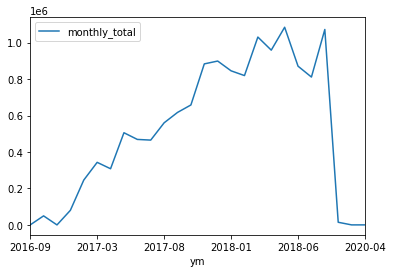

In [23]:
pandas_df = df_agg.orderBy('Y', 'M').toPandas()
pandas_df['ym'] = pandas_df['Y'].apply(lambda x: '{:04d}'.format(x)) + '-' + pandas_df['M'].apply(lambda x: '{:02d}'.format(x))
pandas_df.plot(x='ym', y='monthly_total')

## Load

The `Load` operation refers to save the processed data in some persistent storage engines, e.g. relational databases, key-value stores, object stores, and file systems.

Spark supports write data to most of these popular engines:
* MySQL
* Postgresql
* Elasticserch
* Cassandra
* Kafka
* AWS S3
* Azure Blob
* HDFS
* Alluxio

Let's take writing to csv files as an example. 
```
df_agg.repartition(1).write.mode('overwrite').option('header', 'true').csv('/home/jovyan/output')
```
where
* `repartition(1)` is used to reduce number of output files to 1
* `mode('overwrite')` tells Spark to delete any exisiting data in the output directory 
* `option('header', 'true')` controls if a header line should be added to the csv files

You can try to modify the arguments to observe Spark's writting behavior.

In [34]:
df_agg.repartition(1).write.mode('overwrite').option('header', 'true').csv('output')

In [35]:
!cat output/*.csv

Y,M,monthly_total,monthly_count
2017,3,343242.59999999945,2751
2017,8,560093.3400000128,5042
2017,10,658020.2300000164,5189
2018,1,845279.1800000344,7492
2018,3,1030527.8400000384,8759
2018,8,1072147.7000000272,8815
2017,7,465282.10000000865,4116
2016,9,194.47,4
2018,5,1084358.550000023,8765
2016,10,49580.55000000016,365
2017,12,898920.9800000272,7726
2020,4,199.98,2
2017,9,617046.1200000154,4724
2016,12,10.9,1
2017,4,308148.3199999984,2364
2018,9,14502.499999999987,99
2018,7,811132.0800000194,6672
2020,2,145.98,2
2018,6,870736.8400000221,6897
2017,2,245982.00999999608,1866
2017,11,883351.6300000291,7355
2017,5,505655.46000000933,4150
2018,2,819228.8500000269,7375
2017,6,469001.05000000703,3801
2017,1,80124.73999999998,681
2018,4,958729.7000000284,7637


# Spark SQL

Spark is very powerful and user friendly. However, as you might already noticed, Spark dataframe API still needs us to write `code`, which can be a blocker for people who are not familiar with programming. 

To make Spark more accessible, Spark provides a SQL interface where most common data processing can be expressed by SQL statements. So if you have worked with any relational database before, there is almost nothing stops you to use Spark to process your data.

In order to use SparkSQL, we need to register our dataframe as `TempView` first.

Let's register our `df_user` dataframe as a TempView named `order_items`.

In [26]:
_ = df_user.createOrReplaceTempView('order_items')

Now we can use standard SQL to execute ETL jobs. 

For example, extracting `year`, `month`, `day`:

In [27]:
statement= '''
select
    shipping_limit_date
    ,year(shipping_limit_date) as Y
    ,month(shipping_limit_date) as M
    ,day(shipping_limit_date) as D 
from order_items 
limit 5
'''

spark.sql(statement).show()

+-------------------+----+---+---+
|shipping_limit_date|   Y|  M|  D|
+-------------------+----+---+---+
|2017-09-19 09:45:35|2017|  9| 19|
|2017-05-03 11:05:13|2017|  5|  3|
|2018-01-18 14:48:30|2018|  1| 18|
|2018-08-15 10:10:18|2018|  8| 15|
|2017-02-13 13:57:51|2017|  2| 13|
+-------------------+----+---+---+



Get top 5 sellers who has the largest  number of orders:

In [28]:
statement= '''
select
    seller_id
    ,count(*) as total_order 
from order_items
group by seller_id
order by total_order desc
'''

spark.sql(statement).show(5)

+--------------------+-----------+
|           seller_id|total_order|
+--------------------+-----------+
|6560211a19b47992c...|       2033|
|4a3ca9315b744ce9f...|       1987|
|1f50f920176fa81da...|       1931|
|cc419e0650a3c5ba7...|       1775|
|da8622b14eb17ae28...|       1551|
+--------------------+-----------+
only showing top 5 rows



Get average price per order for each seller. __Note__: We use nested SQL to get the result. Spark also support CTE (Common Table Expression) which makes the statement easier to reader.

In [29]:
statement= '''
select
    seller_id
    ,total_price/total_order as avg_price_per_order
from (
    select
        seller_id
        ,sum(price) as total_price
        ,count(*) as total_order 
    from order_items
    group by seller_id
)
'''

spark.sql(statement).show(5)

+--------------------+-------------------+
|           seller_id|avg_price_per_order|
+--------------------+-------------------+
|ff063b022a9a0aab9...|         125.796875|
|8e6cc767478edae94...|   59.9173684210526|
|a49928bcdf77c55c6...|  83.17641509433946|
|da7039f29f90ce5b4...|  69.94999999999999|
|062ce95fa2ad4dfae...| 125.34999999999992|
+--------------------+-------------------+
only showing top 5 rows



Moreover, Spark SQL also make it possible to run complicated logics that are difficult to programm using dataframe interfaces.

For example, we can use windows query to find top sellers in each month

In [30]:
statement= '''
select
    seller_id
    ,Y
    ,M
    ,total_order
    ,rank() over (
        partition by seller_id order by total_order desc
    ) as rank_total_order
from (
    select
        seller_id
        ,year(shipping_limit_date) as Y
        ,month(shipping_limit_date) as M
        ,count(*) as total_order
    from order_items
    group by Y, M, seller_id
)
'''

spark.sql(statement).show()

+--------------------+----+---+-----------+----------------+
|           seller_id|   Y|  M|total_order|rank_total_order|
+--------------------+----+---+-----------+----------------+
|062ce95fa2ad4dfae...|2017|  5|         21|               1|
|062ce95fa2ad4dfae...|2017|  7|         10|               2|
|062ce95fa2ad4dfae...|2017|  6|          9|               3|
|062ce95fa2ad4dfae...|2017|  3|          6|               4|
|062ce95fa2ad4dfae...|2017|  4|          4|               5|
|062ce95fa2ad4dfae...|2017|  8|          3|               6|
|062ce95fa2ad4dfae...|2017|  2|          3|               6|
|062ce95fa2ad4dfae...|2017|  9|          3|               6|
|062ce95fa2ad4dfae...|2017|  1|          1|               9|
|0b64bcdb0784abc13...|2018|  6|          1|               1|
|0b64bcdb0784abc13...|2018|  7|          1|               1|
|0b64bcdb0784abc13...|2018|  4|          1|               1|
|0b64bcdb0784abc13...|2018|  5|          1|               1|
|0ea22c1cfbdc755f8...|20

__<span style="color:red">Quiz:</span>__: Replace `rank` with `dense_rank` to see the difference.

In [31]:
statement= '''
select
    seller_id
    ,Y
    ,M
    ,total_order
    ,dense_rank() over (
        partition by seller_id order by total_order desc
    ) as rank_total_order
from (
    select
        seller_id
        ,year(shipping_limit_date) as Y
        ,month(shipping_limit_date) as M
        ,count(*) as total_order
    from order_items
    group by Y, M, seller_id
)
'''

spark.sql(statement).show()

+--------------------+----+---+-----------+----------------+
|           seller_id|   Y|  M|total_order|rank_total_order|
+--------------------+----+---+-----------+----------------+
|062ce95fa2ad4dfae...|2017|  5|         21|               1|
|062ce95fa2ad4dfae...|2017|  7|         10|               2|
|062ce95fa2ad4dfae...|2017|  6|          9|               3|
|062ce95fa2ad4dfae...|2017|  3|          6|               4|
|062ce95fa2ad4dfae...|2017|  4|          4|               5|
|062ce95fa2ad4dfae...|2017|  8|          3|               6|
|062ce95fa2ad4dfae...|2017|  2|          3|               6|
|062ce95fa2ad4dfae...|2017|  9|          3|               6|
|062ce95fa2ad4dfae...|2017|  1|          1|               7|
|0b64bcdb0784abc13...|2018|  6|          1|               1|
|0b64bcdb0784abc13...|2018|  7|          1|               1|
|0b64bcdb0784abc13...|2018|  4|          1|               1|
|0b64bcdb0784abc13...|2018|  5|          1|               1|
|0ea22c1cfbdc755f8...|20

__<span style="color:red">Quiz:</span>__: Find the months with 2nd highest number of orders for each seller, whose total number of orders in that month is greater than 10

In [32]:
statement= '''
select *
from (
    select
        seller_id
        ,Y
        ,M
        ,total_order
        ,rank() over (
            partition by seller_id order by total_order desc
        ) as rank_total_order
    from (
        select
            seller_id
            ,year(shipping_limit_date) as Y
            ,month(shipping_limit_date) as M
            ,count(*) as total_order
        from order_items
        group by Y, M, seller_id
    )
)
where 
    total_order > 10 and rank_total_order ==2
'''
spark.sql(statement).show(truncate=False)

+--------------------------------+----+---+-----------+----------------+
|seller_id                       |Y   |M  |total_order|rank_total_order|
+--------------------------------+----+---+-----------+----------------+
|0ea22c1cfbdc755f86b9b54b39c16043|2017|2  |25         |2               |
|8e6cc767478edae941d9bd9eb778d77a|2017|6  |15         |2               |
|a49928bcdf77c55c6d6e05e09a9b4ca5|2017|12 |21         |2               |
|7aa4334be125fcdd2ba64b3180029f14|2017|10 |45         |2               |
|31561f325664a8a7aba4c8d0c3a9b3db|2018|8  |11         |2               |
|537eb890efff034a88679788b647c564|2018|8  |18         |2               |
|537eb890efff034a88679788b647c564|2018|7  |18         |2               |
|602044f2c16190c2c6e45eb35c2e21cb|2017|11 |11         |2               |
|b39d7fe263ef469605dbb32608aee0af|2018|6  |11         |2               |
|ef0ace09169ac090589d85746e3e036f|2018|2  |25         |2               |
|f457c46070d02cadd8a68551231220dd|2018|3  |62      

__<span style="color:red">Quiz:</span>__: Find seller who had more than 100 orders in two consecutive months

In [33]:
statement= '''
with t1 as (
    select
        seller_id
        ,year(shipping_limit_date) as Y
        ,month(shipping_limit_date) as M
        ,count(*) as total_order
    from order_items
    group by Y, M, seller_id
)
select
    a.seller_id
    ,a.Y
    ,a.M
    ,a.total_order
    ,b.M as prev_M
    ,b.total_order as prev_total_order
from 
    t1 as a
join
    t1 as b
on
    a.seller_id = b.seller_id

where
   a.total_order > 100 and b.total_order > 100
    
'''
spark.sql(statement).show(truncate=False)

+--------------------------------+----+---+-----------+------+----------------+
|seller_id                       |Y   |M  |total_order|prev_M|prev_total_order|
+--------------------------------+----+---+-----------+------+----------------+
|7c67e1448b00f6e969d365cea6b010ab|2018|3  |172        |4     |104             |
|7c67e1448b00f6e969d365cea6b010ab|2018|3  |172        |11    |116             |
|7c67e1448b00f6e969d365cea6b010ab|2018|3  |172        |2     |143             |
|7c67e1448b00f6e969d365cea6b010ab|2018|3  |172        |5     |105             |
|7c67e1448b00f6e969d365cea6b010ab|2018|3  |172        |3     |172             |
|955fee9216a65b617aa5c0531780ce60|2018|5  |319        |4     |182             |
|955fee9216a65b617aa5c0531780ce60|2018|5  |319        |1     |251             |
|955fee9216a65b617aa5c0531780ce60|2018|5  |319        |3     |183             |
|955fee9216a65b617aa5c0531780ce60|2018|5  |319        |6     |125             |
|955fee9216a65b617aa5c0531780ce60|2018|5